### 1. Import Relevant Libraries

In [9]:
import pandapower as pp
import numpy as np
import pandapower.plotting as pplt
import matplotlib.pyplot as plt

### 2. Define Network Parameters

In [10]:
buses = [
    {"bus": 1, "vn_kv": 16.5, "type": "b", "code": 3},  
    {"bus": 2, "vn_kv": 18.0, "type": "b", "code":2},  
    {"bus": 3, "vn_kv": 13.8, "type": "b", "code":2},  
    {"bus": 4, "vn_kv": 230.0, "type": "b", "code":1},
    {"bus": 5, "vn_kv": 230.0, "type": "b", "code":1},
    {"bus": 6, "vn_kv": 230.0, "type": "b", "code":1},
    {"bus": 7, "vn_kv": 230.0, "type": "b", "code":1},
    {"bus": 8, "vn_kv": 230.0, "type": "b", "code":1},
    {"bus": 9, "vn_kv": 230.0, "type": "b", "code":1}
]

loads = [
    {"bus": 5, "p_mw": 125.0, "q_mvar": 50.0},
    {"bus": 6, "p_mw": 90.0, "q_mvar": 30.0},
    {"bus": 8, "p_mw": 100.0, "q_mvar": 35.0}
]

lines = [
    {"from_bus": 4, "to_bus": 5, "r_pu": 0.010, "x_pu": 0.068,  "b_pu": 0.176},
    {"from_bus": 4, "to_bus": 6, "r_pu": 0.017, "x_pu": 0.092,  "b_pu": 0.158},
    {"from_bus": 5, "to_bus": 7, "r_pu": 0.032, "x_pu": 0.161,  "b_pu": 0.306},
    {"from_bus": 6, "to_bus": 9, "r_pu": 0.039, "x_pu": 0.1738, "b_pu": 0.358},
    {"from_bus": 7, "to_bus": 8, "r_pu": 0.0085,"x_pu": 0.0576, "b_pu": 0.149},
    {"from_bus": 8, "to_bus": 9, "r_pu": 0.0119,"x_pu": 0.1008, "b_pu": 0.209}
]

transformers = [
    {"hv_bus": 4, "lv_bus": 1, "sn_mva": 100, "vn_hv_kv": 230.0, "vn_lv_kv": 16.5, "vk_percent": 5.76},
    {"hv_bus": 7, "lv_bus": 2, "sn_mva": 100, "vn_hv_kv": 230.0, "vn_lv_kv": 18.0,  "vk_percent": 6.25},
    {"hv_bus": 9, "lv_bus": 3, "sn_mva": 100, "vn_hv_kv": 230.0, "vn_lv_kv": 13.8,  "vk_percent": 5.86}
]

### 3.Create WSCC 9 Bus System

In [11]:
def b_to_cnf(B_pu, V_kv, S_mva=100, f=50):
    """Convert per unit B to capacitance in nF/km"""
    Y_base = S_mva * 1e6 / (V_kv * 1e3)**2 
    C_per_km = B_pu * Y_base / (2 * np.pi * f)     
    return C_per_km * 1e9  

def wscc9_net(buses,loads,lines,transformers):
    net = pp.create_empty_network(sn_mva=100)

    for bus in buses:
        pp.create_bus(net, vn_kv=bus["vn_kv"], name=f"Bus {bus['bus']}", index=bus["bus"], code=bus["code"])

    pp.create_ext_grid(net, bus=1, vm_pu=1.04, name="Slack@Bus1")
    pp.create_gen(net, bus=2, p_mw=163.0, vm_pu=1.025, name="Gen@Bus2")
    pp.create_gen(net, bus=3, p_mw=85.0,  vm_pu=1.025, name="Gen@Bus3")

    for load in loads:
        pp.create_load(net, bus=load["bus"], p_mw=load["p_mw"], q_mvar=load["q_mvar"])

    for line in lines:
        vn_kv = 230.0  
        c_nf = b_to_cnf(line["b_pu"], vn_kv, S_mva=100, f=50)  

        z_base = (vn_kv*1e3)**2 / (100e6)  
        r_ohm_per_km = line["r_pu"] * z_base 
        x_ohm_per_km = line["x_pu"] * z_base

        pp.create_line_from_parameters(
            net,
            from_bus=line["from_bus"], to_bus=line["to_bus"], length_km=1,
            r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km,
            c_nf_per_km=c_nf, max_i_ka=1
        )

    for trafo in transformers:
        pp.create_transformer_from_parameters(
            net,
            hv_bus=trafo["hv_bus"], lv_bus=trafo["lv_bus"],
            sn_mva=trafo["sn_mva"], vn_hv_kv=trafo["vn_hv_kv"], vn_lv_kv=trafo["vn_lv_kv"],
            vk_percent=trafo["vk_percent"], vkr_percent=0.0, pfe_kw=0, i0_percent=0.0
        )

    return net

### 4. Run Power Flow

In [12]:
if __name__ == "__main__":
    net = wscc9_net(buses,loads,lines,transformers)
    pp.runpp(net)

    print("\n--- Bus Voltages (p.u.) ---")
    print(net.res_bus[["vm_pu", "va_degree"]])

    print("\n--- Generator Outputs (MW / MVAr) ---")
    print(net.res_gen[["p_mw", "q_mvar"]])

    print("\n--- Slack Power (MW / MVAr) ---")
    print(net.res_ext_grid[["p_mw", "q_mvar"]])

    print("\n--- Line Flows (MW / MVAr) ---")
    print(net.res_line[["p_from_mw", "q_from_mvar", "p_to_mw", "q_to_mvar", "loading_percent"]])

    print("\n--- Transformer Flows (MW / MVAr) ---")
    print(net.res_trafo[["loading_percent"]])

    print(net.line)



--- Bus Voltages (p.u.) ---
      vm_pu  va_degree
1  1.040000   0.000000
2  1.025000   9.350670
3  1.025000   5.141979
4  1.025307  -2.217409
5  0.999723  -3.680151
6  1.012255  -3.566555
7  1.026832   3.796137
8  1.017266   1.337266
9  1.032689   2.444823

--- Generator Outputs (MW / MVAr) ---
    p_mw     q_mvar
0  163.0   4.903198
1   85.0 -11.448808

--- Slack Power (MW / MVAr) ---
        p_mw     q_mvar
0  71.627461  27.914787

--- Line Flows (MW / MVAr) ---
   p_from_mw  q_from_mvar    p_to_mw  q_to_mvar  loading_percent
0  43.287914    23.450128 -43.007943 -39.592496        14.678109
1  28.339547     1.317466 -28.194699 -16.933310         8.155876
2 -81.992057   -10.407504  84.152149 -10.148127        20.752688
3 -61.805301   -13.066690  63.269797 -17.837741        15.978891
4  78.847851    -0.768451 -78.342615 -11.372475        19.534544
5 -21.657385   -23.627525  21.730203   2.285985         7.909082

--- Transformer Flows (MW / MVAr) ---
   loading_percent
0        73.9180

### 5. Create the simple plot after analyizing the violations

In [13]:
v_max, v_min, max_loading = 1.05, 0.95, 100.0

# Function for analyzing critical elements after a contingency
def analyze_critical_elements(net, title):
    crit_lines, crit_buses, crit_trafos = [], [], []
    for line_idx in net.line.index[net.line.in_service]:
        v_from, v_to = net.res_line.loc[line_idx, ["vm_from_pu", "vm_to_pu"]]
        loading = net.res_line.at[line_idx, "loading_percent"]

        if not (v_min <= v_from <= v_max and v_min <= v_to <= v_max) or loading > max_loading:
            crit_lines.append(line_idx)
                
    for bus_idx in net.bus.index[net.bus.in_service]:
        if not (v_min <= net.res_bus.loc[bus_idx, "vm_pu"] <= v_max):
            crit_buses.append(bus_idx)

    for trafo_idx in net.trafo.index[net.trafo.in_service]:
    #   v_hv, v_lv = net.res_trafo.loc[trafo_idx, ["vm_hv_pu", "vm_lv_pu"]]
        trafo_loading = net.res_trafo.at[trafo_idx, "loading_percent"]

        #if not (v_min <= v_lv <= v_max and v_min <= v_hv <= v_max) or trafo_loading > max_loading:
        if  trafo_loading > max_loading:
            crit_trafos.append(trafo_idx)    

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 6))
    pplt.simple_plot(net, plot_loads=True, plot_gens=True, ax=ax, show_plot=False)

    if crit_lines:
        pplt.draw_collections([pplt.create_line_collection(net, crit_lines, color="r", zorder=3, linewidths=2)], ax=ax)
    if crit_buses:
        pplt.draw_collections([pplt.create_bus_collection(net, crit_buses, size=0.15, color="r", zorder=4)], ax=ax)
    if crit_trafos:
        pplt.draw_collections([pplt.create_trafo_collection(net, crit_trafos, size=0.2, color="r", zorder=5)], ax=ax)

    plt.title(title)
    print(f"Critical Lines: {crit_lines}")
    print(f"Critical Buses: {crit_buses}")
    print(f"Critical Tranformers: {crit_trafos}")
    
    plt.show()

### 6. Create contingency and run power flow

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


Critical Lines: []
Critical Buses: []
Critical Tranformers: [0]


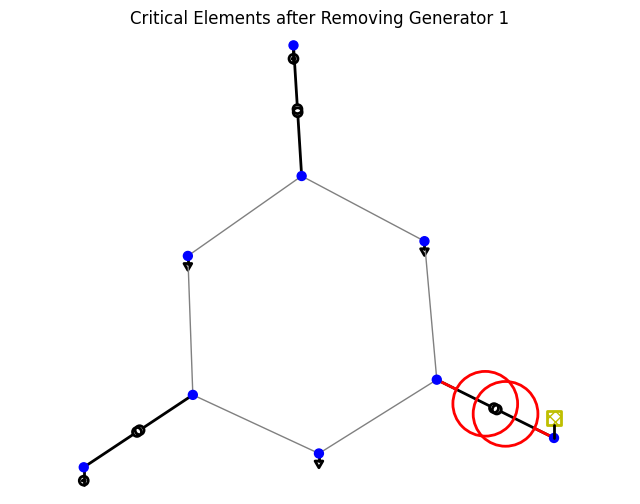


--- Bus Voltages (p.u.) ---
      vm_pu  va_degree
1  1.040000   0.000000
2  1.013510 -14.990467
3  1.025000  -8.573429
4  1.025172  -7.274703
5  0.997393 -12.791297
6  1.012016 -11.622105
7  1.013510 -14.990467
8  1.006937 -15.633577
9  1.027817 -11.283380

--- Generator Outputs (MW / MVAr) ---
   p_mw    q_mvar
0   0.0  0.000000
1  85.0 -2.916755

--- Slack Power (MW / MVAr) ---
         p_mw    q_mvar
0  234.386594  41.67232

--- Line Flows (MW / MVAr) ---
    p_from_mw  q_from_mvar     p_to_mw  q_to_mvar  loading_percent
0  148.525391    17.754424 -146.357033 -21.012369        37.212543
1   85.861203    -6.263342  -84.668055  -3.673338        21.079687
2   21.357033   -28.987631  -21.149340  -0.903937         9.061829
3   -5.331945   -26.326662    5.367104 -10.759099         6.662685
4   21.149340     0.903937  -21.106268 -15.818447         6.575360
5  -78.893732   -19.181553   79.632896   3.807760        20.240575

--- Transformer Flows (MW / MVAr) ---
   loading_percent
0       

In [14]:
def printing(net):
    print("\n--- Bus Voltages (p.u.) ---")
    print(net.res_bus[["vm_pu", "va_degree"]])

    print("\n--- Generator Outputs (MW / MVAr) ---")
    print(net.res_gen[["p_mw", "q_mvar"]])

    print("\n--- Slack Power (MW / MVAr) ---")
    print(net.res_ext_grid[["p_mw", "q_mvar"]])

    print("\n--- Line Flows (MW / MVAr) ---")
    print(net.res_line[["p_from_mw", "q_from_mvar", "p_to_mw", "q_to_mvar", "loading_percent"]])

    print("\n--- Transformer Flows (MW / MVAr) ---")
    print(net.res_trafo[["loading_percent"]])


cont_type = input("Enter contingency type (line/trafo/gen): ").strip().lower()
cont_number = int(input("Enter the element number (e.g., 1 for Line 1): "))

if (cont_number <= 0):
    print(f" Invalid {cont_type} index!")
else:
    i = cont_number-1
    match cont_type:
        case "line":
            net.line.at[i, "in_service"] = False
            try:
                pp.runpp(net)
                analyze_critical_elements(net, f"Critical Elements after Removing Line {cont_number}")
                printing(net)

            except:
                print(f"Power flow did not converge when removing line {cont_number}")
            net.line.at[i, "in_service"] = True

        case "trafo":
            net.trafo.at[i, "in_service"] = False
            try:
                pp.runpp(net)
                analyze_critical_elements(net, f"Critical Elements after Removing Transformer {cont_number}")
                printing(net)

            except:
                print(f"Power flow did not converge when removing transformer {cont_number}")
            net.trafo.at[i, "in_service"] = True

        case "gen":
            net.gen.at[i, "in_service"] = False
            try:
                pp.runpp(net)
                analyze_critical_elements(net, f"Critical Elements after Removing Generator {cont_number}")
                printing(net)
                
            except:
                print(f"Power flow did not converge when removing generator {cont_number}")
            net.gen.at[i, "in_service"] = True

        case _:  
            print("Invalid contingency type. Please enter line/trafo/gen.")    

